In [10]:
import rasterio
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.patches as mpatches
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
import os
import matplotlib.pyplot as plt


os.chdir('/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/Data')

In [9]:
# Open the raster file
with rasterio.open(raster_path) as src:
    crs = src.crs
    print("CRS Information:")
    print(crs)

CRS Information:
EPSG:26913


In [3]:
# Path to your raster file
raster_path = 'final_cleaned_raster.tif'  # Replace with your actual file path

# Open the raster file
with rasterio.open(raster_path) as src:
    raster_data = src.read()  # Read all bands
    raster_meta = src.meta
    crs = src.crs
    transform = src.transform

    # Reproject to EPSG:3857 if necessary
    target_crs = 'EPSG:3857'
    if crs.to_string() != target_crs:
        transform_new, width_new, height_new = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds)
        raster_meta.update({
            'crs': target_crs,
            'transform': transform_new,
            'width': width_new,
            'height': height_new
        })
        raster_data_new = np.empty((src.count, height_new, width_new), dtype=src.meta['dtype'])
        for i in range(1, src.count + 1):
            reproject(
                source=raster_data[i - 1],
                destination=raster_data_new[i - 1],
                src_transform=transform,
                src_crs=crs,
                dst_transform=transform_new,
                dst_crs=target_crs,
                resampling=Resampling.nearest)
        raster_data = raster_data_new
        transform = transform_new

In [4]:
# Define custom colors and normalization
cmap = ListedColormap(['blue', 'red'])  # Customize colors as needed
norm = Normalize(vmin=0, vmax=1)         # Adjust based on your data range

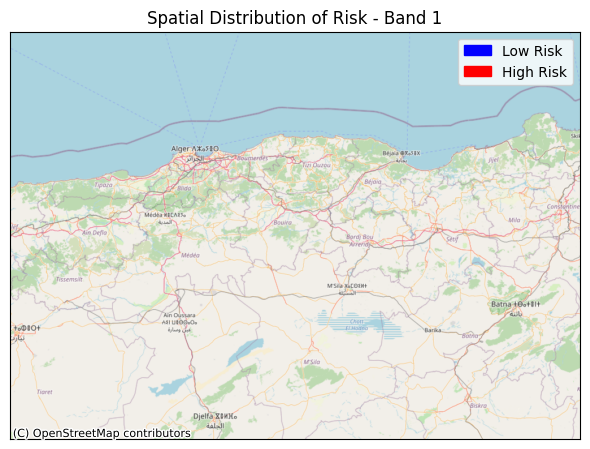

In [5]:
# Number of bands in the raster
num_bands = raster_data.shape[0]

# Create subplots
fig, axes = plt.subplots(1, num_bands, figsize=(6 * num_bands, 6))

# Ensure axes is iterable
if num_bands == 1:
    axes = [axes]

for i in range(num_bands):
    ax = axes[i]
    band = raster_data[i]

    # Plot the raster band
    img = ax.imshow(band, cmap=cmap, norm=norm, extent=rasterio.plot.plotting_extent(src), alpha=0.7)

    # Add base map
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    # Create custom legend
    low_risk_patch = mpatches.Patch(color='blue', label='Low Risk')
    high_risk_patch = mpatches.Patch(color='red', label='High Risk')
    ax.legend(handles=[low_risk_patch, high_risk_patch], loc='upper right')

    # Remove axis ticks for a cleaner look
    ax.set_xticks([])
    ax.set_yticks([])

    # Set title for each subplot
    ax.set_title(f'Spatial Distribution of Risk - Band {i + 1}')

plt.tight_layout()
plt.show()